# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


    
Проект посвящён анализу данных сервиса Яндекс Афиша и проводится с целью изучения поведения пользователей. Его задача - определить, какие клиенты с наибольшей вероятностью возвращаются и совершают повторные покупки, чтобы повысить удержание аудитории и эффективность маркетинговых решений. 
    
<span style="text-decoration:underline;"><u>Структура анализа:</u></span> 
    
1) Знакомство с данными и их подготовка к анализу (содержание и взаимосвязи между таблицами, наличие дубликатов и пропусков, выявление возможных аномалий,  общие характеристики датасета); 
    
2) Выгрузка данных из БД SQL; 

3) Исследовательский анализ данных (формирование профиля потребителя, выделение признаков и факторов повторного приобретения билетов, установление заканомерностей между данными, проведение корреляционногоанализа для выявления аспектов, вляющих на количество заказов); 
    
4) Написание выводов и рекомендация; 
    
5) Публикация проекта на GitHub.


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
!pip install sqlalchemy
!pip install psycopg2-binary
!pip install phik
!pip install python-dotenv

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from dotenv import load_dotenv
from sqlalchemy import create_engine
from phik import phik_matrix

In [5]:
# Загружаем переменные окружения
load_dotenv()

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

In [6]:
# Формируем строку подключения
connection_string = (
    f"postgresql+psycopg2://{db_config['user']}:{db_config['pwd']}"
    f"@{db_config['host']}:{db_config['port']}/{db_config['db']}"
)

In [7]:
# Создаём объект engine для подключения к БД
engine = create_engine(connection_string)

In [8]:
query = '''

WITH purchases_clean AS (
    SELECT
        p.user_id,
        p.device_type_canonical,
        p.order_id,
        p.created_dt_msk AS order_dt,
        p.created_ts_msk AS order_ts,
        p.currency_code,
        p.revenue,
        p.tickets_count,
        p.event_id,
        p.service_name,
        EXTRACT(
            DAY FROM (
                p.created_dt_msk -
                LAG(p.created_dt_msk) OVER (
                    PARTITION BY p.user_id ORDER BY p.created_dt_msk
                )
            )
        ) AS days_since_prev
    FROM afisha.purchases p
    WHERE p.device_type_canonical IN ('mobile', 'desktop')
)

SELECT
    pc.user_id,
    pc.device_type_canonical,
    pc.order_id,
    pc.order_dt,
    pc.order_ts,
    pc.currency_code,
    pc.revenue,
    pc.tickets_count,
    pc.days_since_prev,
    pc.event_id,
    pc.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM purchases_clean pc
LEFT JOIN afisha.events e ON pc.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
WHERE e.event_type_main <> 'фильм'
ORDER BY pc.user_id, pc.order_dt;

'''

In [9]:
df = pd.read_sql_query(query, con=engine)
df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,Весь в билетах,другое,Каменевский регион,Глиногорск
290607,fffcd3dde79eb2c,mobile,368620,2024-10-27,2024-10-27 18:00:57,rub,965.57,4,0.0,33189,Весь в билетах,другое,Каменевский регион,Глиногорск
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,Прачечная,театр,Каменевский регион,Глиногорск
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,Билеты без проблем,стендап,Широковская область,Ягодиновка


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268695 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

Выгрузка данных содержит поля, обозначенные в задании, что говорит об успешности объединения датафреймов.
Пропуски присутствуют в столбце days_since_prev, что является ожидаемым, т.к. они соответсвуют первой покупке пользователя.

<u>Необходимые выполнить:</u>
1) Проверить массив на дубликаты и аномалии; 

2) Проверить корректность данных в столбцах revenue и tickets_count; 

3) Привести столцы с датами к одному формату.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [11]:
# Загружаем таблицу с курсом тенге
tenge_rate_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [12]:
# Преобразуем колонку даты в datetime
tenge_rate_df['data'] = pd.to_datetime(tenge_rate_df['data']).dt.date

In [13]:
# Проверка
tenge_rate_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [14]:
# Слияние по дате заказа
df['order_dt_date'] = df['order_dt'].dt.date
df = df.merge(
    tenge_rate_df[['data', 'curs', 'nominal']],
    left_on='order_dt_date',
    right_on='data',
    how='left'
)

In [15]:
# Пересчёт revenue
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if row['currency_code'] == 'rub'
    else row['revenue'] * (row['curs'] / row['nominal']),
    axis=1
)

In [16]:
# Удаляем колонки order_dt_date и data
df.drop(columns=['order_dt_date', 'data'], inplace=True)

In [17]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,curs,nominal,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск,18.6972,100,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск,18.3419,100,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск,19.6475,100,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск,18.5010,100,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,19.6648,100,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [18]:
# Проверка пропусков
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21916
event_id                     0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
curs                         0
nominal                      0
revenue_rub                  0
dtype: int64

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>

В датасете пропуски обнаружены только в столбце **days_since_prev**.  
Это ожидаемо, так как для первой покупки пользователя отсутствует предыдущий заказ, относительно которого можно рассчитать интервал.  

Пропуски не заполнялись и не удалялись, поскольку они несут корректный смысл и могут быть использованы как признак первой покупки. 

In [19]:
# Проверка наличия полных дубликатов строк
full_duplicates = df.duplicated().sum()

print(f'Количество полных дубликатов строк: {full_duplicates}')

Количество полных дубликатов строк: 0


In [20]:
# Проверка наличия дубликатов по order_id 
order_id_duplicates = df.duplicated(subset=['order_id']).sum()

print(f'Количество дубликатов по order_id: {order_id_duplicates}')

Количество дубликатов по order_id: 0


In [21]:
# Проверка наличия неполных дубликатов заказов
partial_duplicates = df.duplicated(
    subset=[
        'user_id',
        'order_dt',
        'event_id',
        'revenue_rub',
        'tickets_count'
    ]
).sum()

print(f'Количество потенциальных неполных дубликатов: {partial_duplicates}')

Количество потенциальных неполных дубликатов: 53275


<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>

Даполнила проверки на наличие дубликатов по **order_id** и неполных дубликатов заказов. 

Проверка на неполные дубликаты показала наличие заказов с одинаковыми параметрами **user_id, order_dt, event_id, revenue_rub, tickets_count**.
Данные не были удалены, так как они могут отражать реальные повторные покупки пользователя (например, покупку билетов на одно и то же мероприятие несколькими заказами), а не технические дубликаты.


In [22]:
# Преобразование типов данных
df['order_id'] = df['order_id'].astype('int32')
df['event_id'] = df['event_id'].astype('int32')
df['tickets_count'] = df['tickets_count'].astype('int16')
df['currency_code'] = df['currency_code'].astype('category')
df['device_type_canonical'] = df['device_type_canonical'].astype('category')
df['event_type_main'] = df['event_type_main'].astype('category')
df['service_name'] = df['service_name'].astype('category')
df['region_name'] = df['region_name'].astype('category')
df['city_name'] = df['city_name'].astype('category')
df['order_dt'] = pd.to_datetime(df['order_dt'])
df['order_ts'] = pd.to_datetime(df['order_ts'])

In [23]:
# Проверка категориальных значений
for col in ['device_type_canonical','currency_code','event_type_main',
            'service_name','region_name','city_name']:
    print(col, df[col].unique()[:10])

device_type_canonical ['mobile', 'desktop']
Categories (2, object): ['mobile', 'desktop']
currency_code ['rub', 'kzt']
Categories (2, object): ['rub', 'kzt']
event_type_main ['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт', 'ёлки']
Categories (7, object): ['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт', 'ёлки']
service_name ['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!', 'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная', 'Быстробилет', 'Дом культуры']
Categories (36, object): ['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!', ..., 'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете']
region_name ['Каменевский регион', 'Североярская область', 'Озернинский край', 'Лугоградская область', 'Поленовский край', 'Широковская область', 'Медовская область', 'Златопольский округ', 'Малиновоярский округ', 'Яблоневская область']
Categories (81, object): ['Каменевский регион', 'Североярская область', 'Озернинский край', 'Лугоградская о

In [24]:
df.replace(['-', 'None', 'none', ' ', '', ' ...'], np.nan, inplace=True)

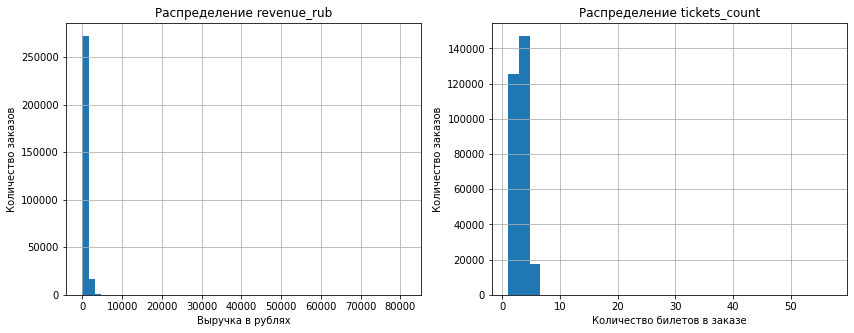

In [25]:
# Проверка выбросов в revenue_rub и tickets_count
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
df['revenue_rub'].hist(bins=50)
plt.title('Распределение revenue_rub')
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество заказов')

plt.subplot(1,2,2)
df['tickets_count'].hist(bins=30)
plt.title('Распределение tickets_count')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов')

plt.show()

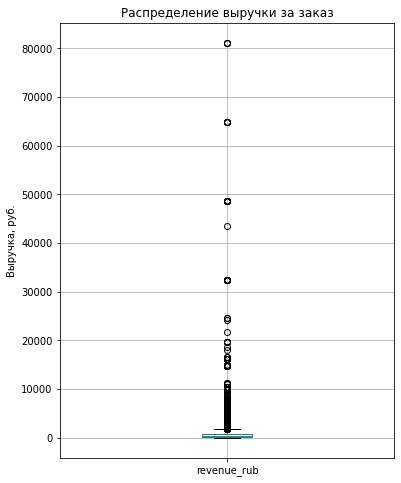

In [26]:
ax = df.boxplot(column='revenue_rub', figsize=(6, 8))
ax.set_title('Распределение выручки за заказ')
ax.set_ylabel('Выручка, руб.')

plt.show()

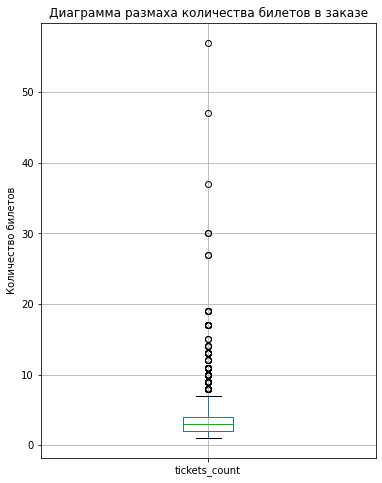

In [27]:
ax = df.boxplot(column='tickets_count', figsize=(6, 8))

ax.set_title('Диаграмма размаха количества билетов в заказе')
ax.set_ylabel('Количество билетов')

plt.show()

In [28]:
# Анализ отрицательных значений выручки
(df['revenue_rub'] < 0).mean() * 100

df = df[df['revenue_rub'] > 0].copy()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284704 entries, 0 to 290610
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                284704 non-null  object        
 1   device_type_canonical  284704 non-null  category      
 2   order_id               284704 non-null  int32         
 3   order_dt               284704 non-null  datetime64[ns]
 4   order_ts               284704 non-null  datetime64[ns]
 5   currency_code          284704 non-null  category      
 6   revenue                284704 non-null  float64       
 7   tickets_count          284704 non-null  int16         
 8   days_since_prev        263127 non-null  float64       
 9   event_id               284704 non-null  int32         
 10  service_name           284704 non-null  category      
 11  event_type_main        284704 non-null  category      
 12  region_name            284704 non-null  cate

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>

На базе анализа отрицательных значений выручки было отфильтровано порядка 2% данных. </div>

In [30]:
# Отфильтровываем выбросы по revenue_rub
p99 = df['revenue_rub'].quantile(0.99)
df_filtered = df[df['revenue_rub'] <= p99].copy()

removed = len(df) - len(df_filtered)
removed_pct = removed / len(df)

removed, round(removed_pct*100, 2)

(2825, 0.99)

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>

Фильтрация данных: 
    
В поле **revenue_rub** наблюдаются экстремальные значения, связанные, что может говорить о корпоративных заказах.  
Для снижения влияния таких наблюдений выручка была ограничена 99-м перцентилем. В результате было удалено около 1% данных, что не является критичным для анализа.

    
В поле **tickets_count** также присутствуют большие значения (например, 50+ билетов), однако они могут соответствовать реальным групповым покупкам. Так как целью анализа является изучение повторных заказов пользователей, а не среднего размера заказа, в данном случае данные не корректировала.

1) Единственный ожидаемый столбец с пропусками — days_since_prev, что соответствует первой покупке пользователя; 

2) Выполнено преобразование типов данных (order_dt, order_ts) к datetime64, (order_id, event_id) к int32 и (tickets_count) к int16; номинальные признаки приведены к категориальным; 

3) В категориальных данных проведена нормализация данных; 

4) Выбросы в revenue_rub связаны с корпоративными / групповыми заказами.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [31]:
# Сортировка по пользователю и дате заказа
df_sorted = df.sort_values(by=['user_id', 'order_dt'])

In [32]:
# Агрегация 
user_profile = df_sorted.groupby('user_id').agg(
    first_order_dt=('order_dt', 'first'),
    last_order_dt=('order_dt', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between_orders=('days_since_prev', 'mean')
).reset_index()

In [33]:
# Добавление бинарных признаков
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

In [34]:
# Заполнить avg_days_between_orders нулями
user_profile['avg_days_between_orders'] = (
    user_profile['avg_days_between_orders'].fillna(0))

In [35]:
# Округление метрик
user_profile['avg_revenue'] = user_profile['avg_revenue'].round(2)
user_profile['avg_tickets'] = user_profile['avg_tickets'].round(2)
user_profile['avg_days_between_orders'] = user_profile['avg_days_between_orders'].round(1)

In [36]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4.00,0.0,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.01,3.00,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.21,2.67,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.83,4.00,0.0,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1.50,16.0,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [37]:
# Расчет показателей
total_users = len(user_profile)
avg_revenue_per_order = user_profile['avg_revenue'].mean()
percent_two_orders = (user_profile['is_two'].sum() / total_users) * 100
percent_five_orders = (user_profile['is_five'].sum() / total_users) * 100
#percent_two_orders = user_profile['is_two'].mean() * 100
#percent_five_orders = user_profile['is_five'].mean() * 100

print(f"Общее число пользователей: {total_users}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб")
print(f"Доля пользователей с 2 и более заказами: {percent_two_orders:.2f}%")
print(f"Доля пользователей с 5 и более заказами: {percent_five_orders:.2f}%")

Общее число пользователей: 21779
Средняя выручка с одного заказа: 581.79 руб
Доля пользователей с 2 и более заказами: 61.78%
Доля пользователей с 5 и более заказами: 29.04%


In [38]:
# Изучение стат пок-ей - Количество заказов
print("Общее число заказов:")
print(user_profile['total_orders'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99]))

Общее число заказов:
count    21779.000000
mean        13.072409
std        120.569323
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
95%         31.000000
99%        152.000000
max      10057.000000
Name: total_orders, dtype: float64


In [39]:
# Изучение стат пок-ей - Ср число билетов
print("Среднее число билетов в заказе:")
print(user_profile['avg_tickets'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99]))

Среднее число билетов в заказе:
count    21779.000000
mean         2.758941
std          0.921952
min          1.000000
25%          2.000000
50%          2.770000
75%          3.140000
95%          4.000000
99%          5.000000
max         12.000000
Name: avg_tickets, dtype: float64


In [40]:
# Изучение стат пок-ей - Ср количество дней между покупками
print("Среднее количество дней между покупками:")
print(user_profile['avg_days_between_orders'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99]))

Среднее количество дней между покупками:
count    21779.000000
mean         9.851701
std         19.200182
min          0.000000
25%          0.000000
50%          0.000000
75%         11.800000
95%         47.520000
99%        101.000000
max        148.000000
Name: avg_days_between_orders, dtype: float64


<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span> 

**1) Анализ по параметру "Количество заказов":** 
- Ср значение равно 13 заказам на пользователя, в том время как половина пользователей совершила 2 и менее заказа; 
- Максимальнок кол-во заказов равно 10 251 - аномалия (возможно корпоративный аккаунт) - может потребоваться удаление; 
- большинство пользователей делают 32 заказа, очень активные - 152. 

**2) Анализ по параметру "Ср число билетов":** 
- Медианное и ср значение практически равны, что говорит о симметричном распределнии данных; 
- Масимальное количество билетов, купленных за раз равно 12; 
- Большинство заказов содержат 2-3 билета, распределение плотное.

**3) Анализ по параметру "Ср количество дней между покупками":** 
- Среднее количество дней между покупками приблизительно равно 10 дням; 
- Большая часть пользователей делает покупки раз в 1,5-2 месяца (48 день); 
- Явные редкие покупки - раз в 148 дней; 
- Интервалы между покупками различны, что говрит о скошенности распределения вправо.


<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>

Показатель **total_orders** имеет выраженное правостороннее смещение: при медиане в 2 заказа максимальное значение превышает 10000 заказов на пользователя. Подобные значения могут быть связаны с корпоративными аккаунтами. Так как цель исследования - анализ возвратности пользователей, а не прогнозирование среднего чека или нагрузки, данные наблюдения не были исключены из датасета.


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [41]:
# Выделение первого заказа у каждого пользователя
df_sorted = df.sort_values(by=['user_id', 'order_dt'])
first_orders = df_sorted.groupby('user_id').first().reset_index()

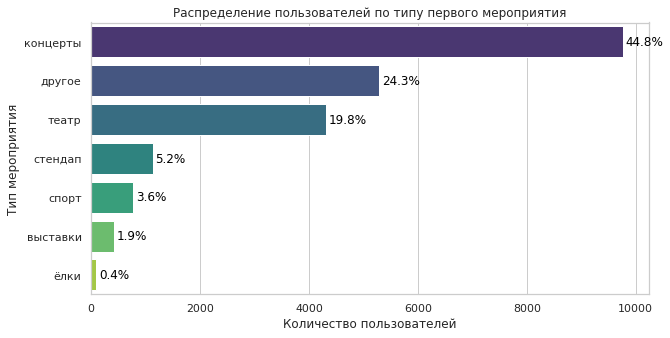

In [42]:
# Распределение по параметру "Тип первого мероприятия"
first_event_dist = first_orders['event_type_main'].value_counts().reset_index()
first_event_dist.columns = ['event_type_main', 'users_count']
first_event_dist['share'] = first_event_dist['users_count'] / first_event_dist['users_count'].sum()

sns.set(style="whitegrid")
plt.figure(figsize=(10,5))

ax = sns.barplot(
    x='users_count',
    y='event_type_main',
    data=first_event_dist,
    order=first_event_dist.sort_values('users_count', ascending=False)['event_type_main'],  
    palette='viridis'
)

plt.title('Распределение пользователей по типу первого мероприятия')
plt.xlabel('Количество пользователей')
plt.ylabel('Тип мероприятия')


for i, row in first_event_dist.iterrows():
    ax.text(
        row['users_count'] + 50,  
        i,                         
        f"{row['share']*100:.1f}%",   
        color='black',
        va='center'
    )

plt.show()

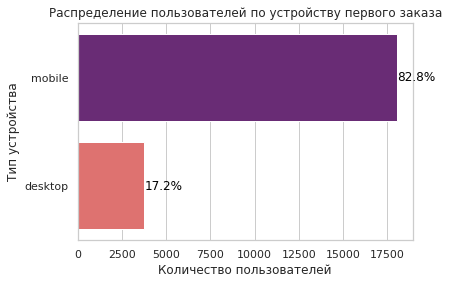

In [43]:
# Распределение по параметру "Тип устройства, с которого совершена первая покупка"
first_device_dist = first_orders['device_type_canonical'].value_counts().reset_index()
first_device_dist.columns = ['first_device', 'users_count']
first_device_dist['share'] = first_device_dist['users_count'] / first_device_dist['users_count'].sum()


order = first_device_dist.sort_values('users_count', ascending=False)['first_device']

ax = sns.barplot(
    x='users_count',
    y='first_device',
    data=first_device_dist,
    palette='magma',
    order=order
)

plt.title('Распределение пользователей по устройству первого заказа')
plt.xlabel('Количество пользователей')
plt.ylabel('Тип устройства')

for i, row in first_device_dist.iterrows():
    ax.text(
        row['users_count'] + 50,       
        i,                             
        f"{row['share']*100:.1f}%",  
        color='black',
        va='center'
    )

plt.show()

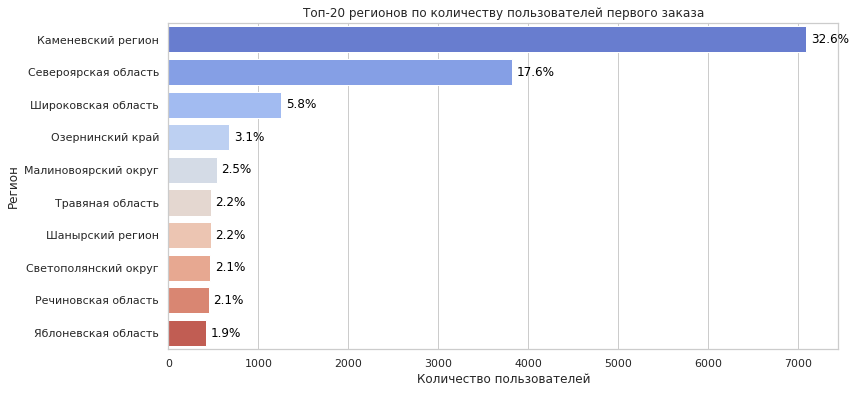

In [44]:
# Распределение по параметру "Регион проведения мероприятия из первого заказа"
first_region_dist = first_orders['region_name'].value_counts().reset_index()
first_region_dist.columns = ['region_name', 'users_count']
first_region_dist['share'] = first_region_dist['users_count'] / first_region_dist['users_count'].sum()
first_region_dist

top_regions = first_region_dist.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='users_count',
    y='region_name',
    data=top_regions,
    order=top_regions.sort_values('users_count', ascending=False)['region_name'],
    palette='coolwarm'
)

plt.title('Топ-20 регионов по количеству пользователей первого заказа')
plt.xlabel('Количество пользователей')
plt.ylabel('Регион')


for i, row in top_regions.iterrows():
    ax.text(
        row['users_count'] + 50,       
        i,                             
        f"{row['share']*100:.1f}%",  
        color='black',
        va='center'
    )

plt.show()

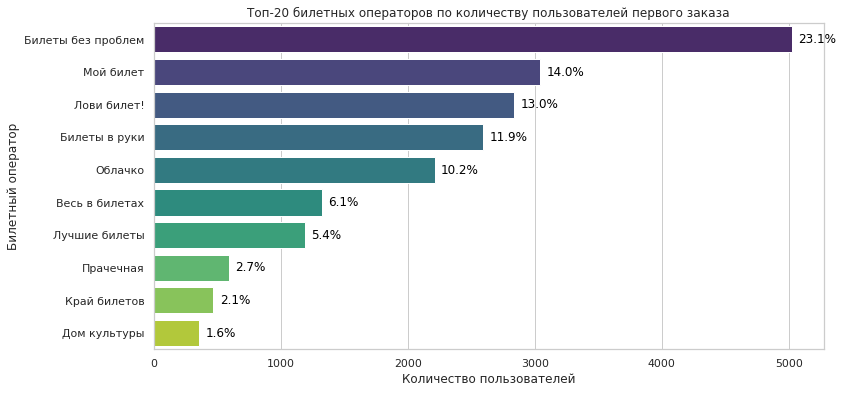

In [45]:
# Распределение по параметру "Билетный оператор, продавший билеты на первый заказ"
first_service_dist = first_orders['service_name'].value_counts().reset_index()
first_service_dist.columns = ['service_name', 'users_count']
first_service_dist['share'] = first_service_dist['users_count'] / first_service_dist['users_count'].sum()
first_service_dist

top_services = first_service_dist.head(10)

plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='users_count',
    y='service_name',
    data=top_services,
    order=top_services.sort_values('users_count', ascending=False)['service_name'],
    palette='viridis'
)

plt.title('Топ-20 билетных операторов по количеству пользователей первого заказа')
plt.xlabel('Количество пользователей')
plt.ylabel('Билетный оператор')


for i, row in top_services.iterrows():
    ax.text(
        row['users_count'] + 50,       
        i,                             
        f"{row['share']*100:.1f}%",  
        color='black',
        va='center'
    )

plt.show()

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>

В целом распределение пользователей по всем рассматриваемым признакам является неравномерным. 
    
- По типу первого мероприятия основная часть пользователей начинает взаимодействие с платформой через наиболее массовые и популярные форматы досуга.Менее массовые категории встречаются реже, что может быть связано с меньшей частотой проведения таких событий / более узкой целевой аудиторией.

- По типу устройства наблюдается явное доминирование мобильных устройств. Это может быть связано с привычками пользователей искать и покупать билеты в моменте, используя смартфон, а также с удобством мобильного интерфейса.

- По регионам распределение также неравномерно: значительная доля пользователей сконцентрирована в ограниченном числе регионов, что, может отражать разницу в плотности населения, количестве мероприятий и уровне развития культурной инфраструктуры.

- Анализ билетных операторов показал наличие нескольких лидеров, через которых проходит основная часть первых заказов.
Это может быть связано как с эксклюзивными контрактами, так и с более удобным пользовательским опытом или широтой ассортимента.


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


**Под фразой "Для каждого сегмента" понимаю, что необходимо использовать классификацию предыдущего задания, т.е. проанализировать по 4 сегментам: по типу первого мероприятия, по типу устройства, с которого совершена первая покупка, по региону проведения мероприятия из первого заказа и по билетному оператору, продавший билеты на первый заказ.**

**Данный анализ проводится с целью понимания, какие сегменты пользователей чаще возвращаются для повторной покупки.**

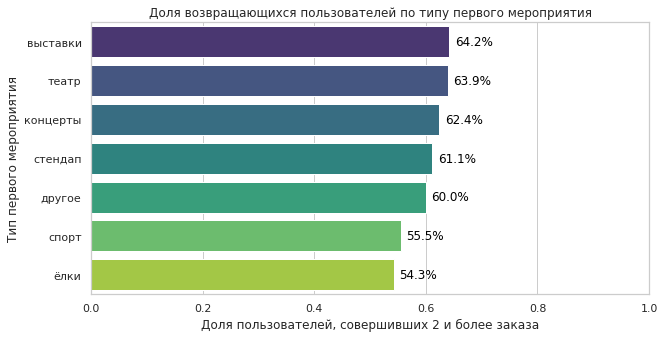

In [46]:
# Доля возвращающихся пользователей по типу первого мероприятия

# Группировка по типу первого мероприятия
event_return = user_profile.groupby('first_event_type').agg(
    users_count=('user_id', 'count'),
    returned_share=('is_two', 'mean')
).reset_index()

# Сортировка по доле возвращающихся пользователей по убыванию
event_return = event_return.sort_values(by='returned_share', ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    x='returned_share', 
    y='first_event_type', 
    data=event_return,
    palette='viridis'
)
plt.xlabel('Доля пользователей, совершивших 2 и более заказа')
plt.ylabel('Тип первого мероприятия')
plt.title('Доля возвращающихся пользователей по типу первого мероприятия')
plt.xlim(0,1)

# Добавляем подписи с процентами
for p in ax.patches:
    width = p.get_width()           
    y = p.get_y() + p.get_height()/2 
    ax.text(
        width + 0.01,             
        y, 
        f"{width*100:.1f}%",        
        va='center', 
        color='black'
    )

plt.show()

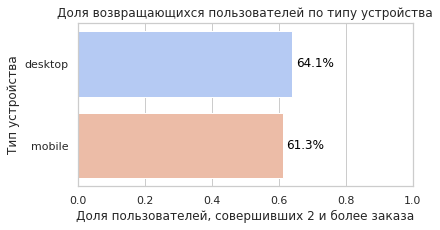

In [47]:
# Доля возвращающихся пользователей по типу устройства

# Группировка по типу устройства первого заказа
device_return = user_profile.groupby('first_device').agg(
    users_count=('user_id', 'count'),
    returned_share=('is_two', 'mean')
).reset_index()

# Сортировка по доле возвращающихся пользователей по убыванию
device_return = device_return.sort_values(by='returned_share', ascending=False)

plt.figure(figsize=(6,3))
ax = sns.barplot(
    x='returned_share', 
    y='first_device', 
    data=device_return,
    palette='coolwarm'
)
plt.xlabel('Доля пользователей, совершивших 2 и более заказа')
plt.ylabel('Тип устройства')
plt.title('Доля возвращающихся пользователей по типу устройства')
plt.xlim(0,1)

for p in ax.patches:
    width = p.get_width()           
    y = p.get_y() + p.get_height()/2  
    ax.text(
        width + 0.01,              
        y, 
        f"{width*100:.1f}%",        
        va='center', 
        color='black'
    )

plt.show()

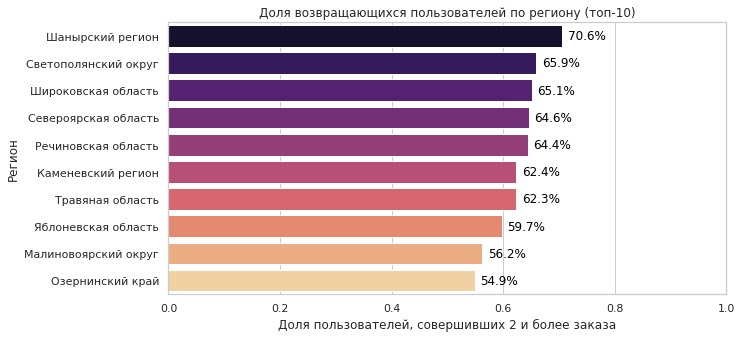

In [48]:
# Доля возвращающихся пользователей по региону (ТОП-10)

# Группировка по региону первого заказа
region_return = user_profile.groupby('first_region').agg(
    users_count=('user_id', 'count'),
    returned_share=('is_two', 'mean')
).reset_index()

# Сортировка по числу пользователей и выбор топ-10
region_return_top10 = region_return.sort_values(by='users_count', ascending=False).head(10)

# Сортировка топ-10 по доле возвращающихся пользователей по убыванию
region_return_top10 = region_return_top10.sort_values(by='returned_share', ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    x='returned_share', 
    y='first_region', 
    data=region_return_top10,
    palette='magma'
)
plt.xlabel('Доля пользователей, совершивших 2 и более заказа')
plt.ylabel('Регион')
plt.title('Доля возвращающихся пользователей по региону (топ-10)')
plt.xlim(0,1)

for p in ax.patches:
    width = p.get_width()           
    y = p.get_y() + p.get_height()/2  
    ax.text(
        width + 0.01,               
        y,
        f"{width*100:.1f}%",        
        va='center',
        color='black'
    )

plt.show()

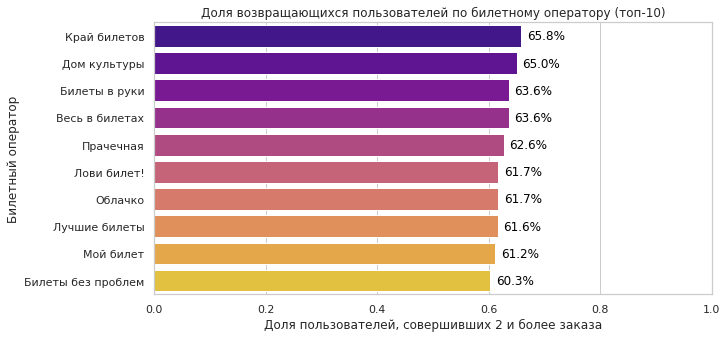

In [49]:
# Доля возвращающихся пользователей по билетному оператору (ТОП-10)

# Группировка по билетному оператору первого заказа
service_return = user_profile.groupby('first_service').agg(
    users_count=('user_id', 'count'),
    returned_share=('is_two', 'mean')
).reset_index()

# Сортировка по числу пользователей и выбор топ-10
service_return_top10 = service_return.sort_values(by='users_count', ascending=False).head(10)

service_return_top10 = service_return_top10.sort_values(by='returned_share', ascending=False)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    x='returned_share',
    y='first_service',
    data=service_return_top10,
    palette='plasma'
)
plt.xlabel('Доля пользователей, совершивших 2 и более заказа')
plt.ylabel('Билетный оператор')
plt.title('Доля возвращающихся пользователей по билетному оператору (топ-10)')
plt.xlim(0,1)

for p in ax.patches:
    width = p.get_width()           
    y = p.get_y() + p.get_height()/2  
    ax.text(
        width + 0.01,               
        y,
        f"{width*100:.1f}%",        
        va='center',
        color='black'
    )

plt.show()

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>

**1) Анализ по параметру "Тип первого мероприятия":** 
    
- Основная масса пользователей приходит через популярные категории: «Выставки», «Театр» и «Концерты». Эти сегменты являются «точками входа» на платформу, так как именно на эти мероприятия проще привлечь массовую аудиторию; 
- Менее популярные категории, такие как «Спорт» и «Ёлки», реже становятся причиной повторных заказов. Это может быть связано с более редкой периодичностью событий или узкой целевой аудиторией; 
- Цифровое подтверждение: доля возвращающихся пользователей в топ-3 категорий превышает 60%, тогда как для менее популярных категорий она около 55%.
    
**2) Анализ по параметру "Тип устройства, с которого совершена покупка":** 

- Большинство пользователей делают первый заказ с мобильных устройств, что отражает тенденцию к мобильному потреблению контента;
- Распределение повторных заказов примерно одинаково между мобильными и десктопными пользователями, что говорит о том, что тип устройства не сильно влияет на вероятность возврата, хотя основной поток приходит с мобильных.
- Около 83% первых заказов совершаются с мобильных, при этом доля повторных заказов около 60% для обоих типов устройств.

**3) Анализ по параметру "Регион проведения мероприятия":** 
- Пользователи из крупных регионов чаще возвращаются на платформу. Это объяснимо большим количеством мероприятий и удобством доступа;
- Сегменты с малой численностью показывают высокую вариацию доли повторных заказов, что требует осторожности при интерпретации.

**4) Анализ по параметру "Билетный оператор":** 
- Лидеры по повторным заказам — «Край билетов», «Дом культуры», «Весь в билетах». Эти операторы, вероятно, обеспечивают удобный сервис, понятные условия покупки и лояльную аудиторию.
- Операторы с небольшим количеством пользователей демонстрируют нестабильную долю возвращающихся, поэтому на них делать выводы о поведении пользователей нецелесообразно.


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [50]:
# Гипотеза 1

# Группировка по типу первого мероприятия
event_return_hyp1 = user_profile.groupby('first_event_type').agg(
    users_count=('user_id', 'count'),
    returned_share=('is_two', 'mean')
).reset_index()

# Сравниваем долю для спортивных мероприятий и концертов
sports_return = event_return_hyp1.loc[event_return_hyp1['first_event_type'] == 'спорт', 'returned_share'].values[0]
concert_return = event_return_hyp1.loc[event_return_hyp1['first_event_type'] == 'концерты', 'returned_share'].values[0]

print(f"Доля возвращающихся пользователей для спорта: {sports_return:.2%}")
print(f"Доля возвращающихся пользователей для концертов: {concert_return:.2%}")

Доля возвращающихся пользователей для спорта: 55.47%
Доля возвращающихся пользователей для концертов: 62.39%


In [51]:
# Гипотеза 2

# Группировка по региону
region_return_hyp2 = user_profile.groupby('first_region').agg(
    users_count=('user_id', 'count'),
    returned_share=('is_two', 'mean')
).reset_index()

# Находим топ-10 по числу пользователей
top_regions = region_return_hyp2.sort_values('users_count', ascending=False).head(10)
top_regions_mean = top_regions['returned_share'].mean()

# Сравнение с менее активными регионами
less_active_regions = region_return_hyp2[~region_return_hyp2['first_region'].isin(top_regions['first_region'])]
less_active_mean = less_active_regions['returned_share'].mean()

print(f"Средняя доля возвращающихся пользователей в топ-10 активных регионах: {top_regions_mean:.2%}")
print(f"Средняя доля в менее активных регионах: {less_active_mean:.2%}")

Средняя доля возвращающихся пользователей в топ-10 активных регионах: 62.61%
Средняя доля в менее активных регионах: 55.36%


<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Гипотеза 1.</u></span>
Гипотеза не верна, т.к.доля возвращающихся кользователей, приобретавших билеты на концерты, выше, чем доля возвращающихся кользователей, приобретавших билеты на спортивные мероприятия. 

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Гипотеза 2.</u></span>
Данная гипотеза верна. 

Графическое представление распределений приведено в задаче выше.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


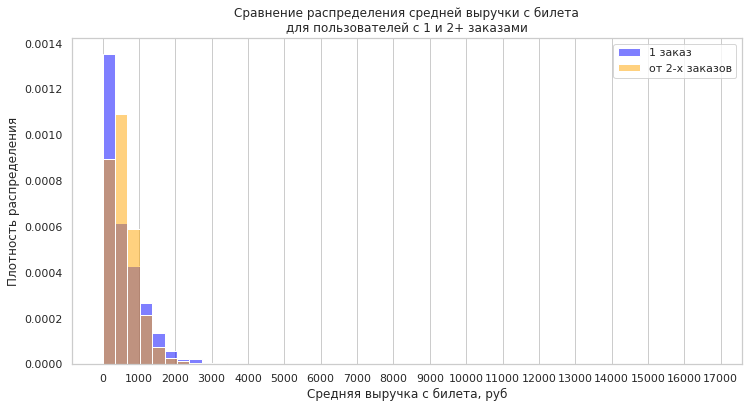

In [52]:
# Создаём столбец средней выручки с билета
user_profile['avg_revenue_rub'] = user_profile['avg_revenue']

# Разделяем пользователей на две группы
one_order = user_profile[user_profile['is_two'] == 0]['avg_revenue_rub']
returned = user_profile[user_profile['is_two'] == 1]['avg_revenue_rub']

# Определяем интервалы для гистограммы
max_value = max(user_profile['avg_revenue_rub'].max(), 5000)
bins = np.linspace(0, max_value, 50)

# Построение гистограммы
plt.figure(figsize=(12,6))
sns.histplot(one_order, bins=bins, color='blue', alpha=0.5, label='1 заказ', stat='density')
sns.histplot(returned, bins=bins, color='orange', alpha=0.5, label='от 2-х заказов', stat='density')

plt.xlabel('Средняя выручка с билета, руб')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки с билета\nдля пользователей с 1 и 2+ заказами')
plt.legend()
plt.grid(axis='y', alpha=0.3)

step = 1000
plt.xticks(np.arange(0, max_value + step, step))

plt.show()

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>
- Пользователи с одним заказом состредоточены в диапозоне низкой выручки и в диапозоне от 1000 руб до 2800 руб; 
- Пользователи, совершившие от 2-х и более заказов, в диапозоне средней выручки от 300 руб до 1000 руб; 
- Распределение говорит о том, что более «лояльные» пользователи, совершающие повторные покупки, склонны делать как мелкие, так и более крупные по стоимости заказы, в то время как пользователи с одним заказом чаще ограничиваются покупками с низкой средней выручкой.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


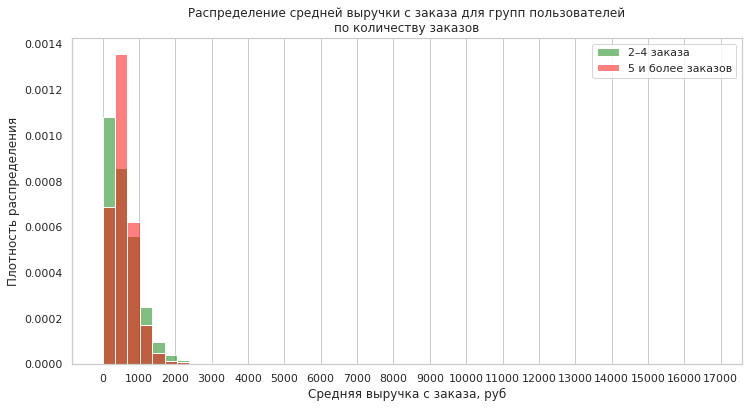

In [53]:
# Разделяем пользователей на группы
group_2_4 = user_profile[(user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)]['avg_revenue_rub']
group_5_plus = user_profile[user_profile['is_five'] == 1]['avg_revenue_rub']

# Построение гистограммы
plt.figure(figsize=(12,6))
sns.histplot(group_2_4, bins=bins, color='green', alpha=0.5, label='2–4 заказа', stat='density')
sns.histplot(group_5_plus, bins=bins, color='red', alpha=0.5, label='5 и более заказов', stat='density')

plt.xlabel('Средняя выручка с заказа, руб')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки с заказа для групп пользователей\nпо количеству заказов')
plt.legend()
plt.grid(axis='y', alpha=0.3)

step = 1000
plt.xticks(np.arange(0, max_value + step, step))

plt.show()

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span>
- Пользователи, совершившие от 2-х до 4-х заказов, находятся в диапозоне средней выручки от 300 руб до 1000 руб; 
- Пользователи, совершившие от 5-ти и более заказов, в диапозоне низкой выручки и в диапозоне от 1000 руб до 2500 руб. Также пользователи с 5 и более заказами (красная гистограмма) имеют чуть более выраженный пик плотности в самых низких значениях средней выручки. Это может означать, что среди более активных пользователей много тех, кто делает частые, но недорогие заказы.; 
- Основной пик обеих групп находится в низком диапазоне — около 0–1000 рублей. Это говорит о том, что большинство пользователей в обеих группах в среднем тратят относительно небольшие суммы за заказ; 
- Максимальные значения средней выручки у обеих групп достигают примерно одинаковых значений (до 17000 рублей), но такие случаи редкие выбросы.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

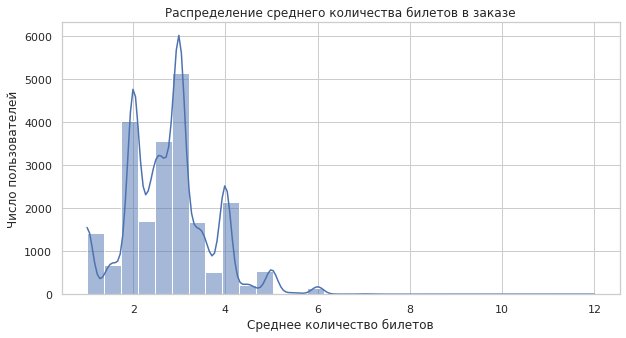

In [54]:
# Распределение пользователей по среднему количеству билетов в заказе
plt.figure(figsize=(10, 5))
sns.histplot(user_profile['avg_tickets'], bins=30, kde=True)
plt.title('Распределение среднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов')
plt.ylabel('Число пользователей')

plt.show()

In [55]:
# Создание сегментов по среднему количеству билетов в заказе
bins = [1, 2, 3, 5, user_profile['avg_tickets'].max()+1]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5 и более билетов']

user_profile['tickets_segment'] = pd.cut(user_profile['avg_tickets'], bins=bins, labels=labels, right=False)

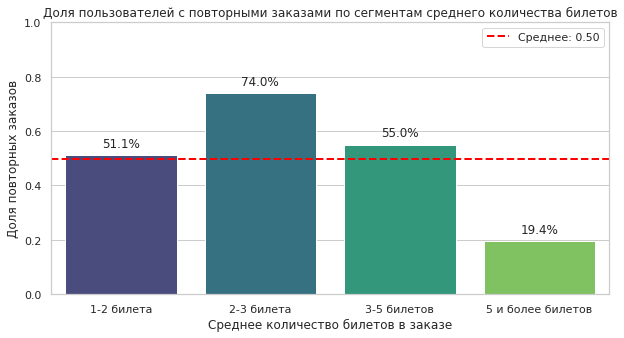

In [56]:
# Расчет общего числа пользователей и долей пользователей, совершивших повторные заказы
segment_stats = user_profile.groupby('tickets_segment').agg(
    users_count=('user_id', 'count'),
    repeat_share=('is_two', 'mean')
).reset_index()

segment_stats['repeat_share_percent'] = (segment_stats['repeat_share'] * 100).round(1)
segment_stats

# Среднее значение доли повторных заказов (ДОБАВЛЕНИЕ)
mean_repeat_share = segment_stats['repeat_share'].mean()

plt.figure(figsize=(10,5))
sns.barplot(x='tickets_segment', y='repeat_share', data=segment_stats, palette='viridis')

plt.title('Доля пользователей с повторными заказами по сегментам среднего количества билетов')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Доля повторных заказов')
plt.ylim(0, 1)

for i, row in segment_stats.iterrows():
    plt.text(i, row['repeat_share'] + 0.03, f"{row['repeat_share_percent']}%", ha='center')


plt.axhline(mean_repeat_share, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_repeat_share:.2f}')

plt.legend()
plt.show()

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span> 

Согласно распределению, вероятность того, что клиент повторно купит от 5 и более билетов составляет примерно 19,3% (основными составляющими данного сегмента могут быть корпоративные клиенты). Чаще всего повторно приобретаются 2-3 билета. В диапозоне 51%-55% находятся сегменты потребителей, приобретающих 1-2 билета и 3-5 билетов. 

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [57]:
# Выделение дня недели
user_profile['first_order_dt'] = pd.to_datetime(user_profile['first_order_dt'])

user_profile['first_order_weekday'] = user_profile['first_order_dt'].dt.dayofweek
weekday_map = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
user_profile['first_order_weekday_name'] = user_profile['first_order_weekday'].map(weekday_map)

In [58]:
# Расчет метрик
weekday_stats = user_profile.groupby('first_order_weekday_name').agg(
    users_count=('user_id', 'count'),
    repeat_share=('is_two', 'mean')
).reset_index()

# Сортируем дни недели по порядку
weekday_stats['weekday_num'] = weekday_stats['first_order_weekday_name'].map({v: k for k, v in weekday_map.items()})
weekday_stats = weekday_stats.sort_values('weekday_num')

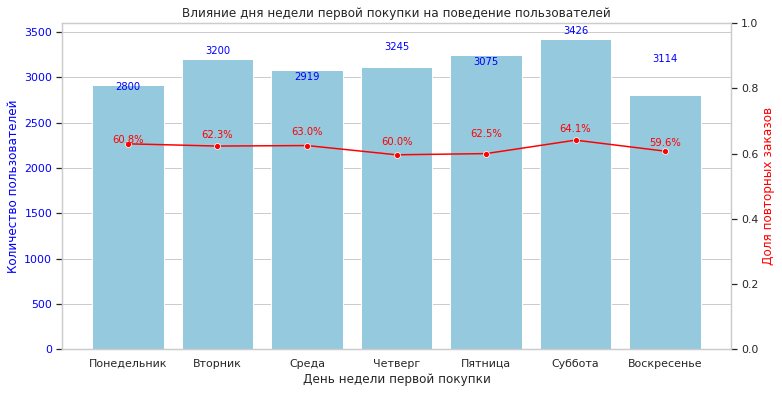

In [59]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Столбчатая диаграмма — количество пользователей
sns.barplot(x='first_order_weekday_name', y='users_count', data=weekday_stats, ax=ax1, color='skyblue')
ax1.set_ylabel('Количество пользователей', color='blue')
ax1.set_xlabel('День недели первой покупки')
ax1.tick_params(axis='y', labelcolor='blue')

for index, row in weekday_stats.iterrows():
    ax1.text(index, row['users_count'] + max(weekday_stats['users_count']) * 0.01, 
             f"{row['users_count']}", color='blue', ha='center', va='bottom', fontsize=10)

# Создаём второй y-axis для доли повторных заказов
ax2 = ax1.twinx()
sns.lineplot(x='first_order_weekday_name', y='repeat_share', data=weekday_stats, ax=ax2, color='red', marker='o')
ax2.set_ylabel('Доля повторных заказов', color='red')
ax2.set_ylim(0, 1)

for index, row in weekday_stats.iterrows():
    ax2.text(index, row['repeat_share'] + 0.02, 
             f"{row['repeat_share']*100:.1f}%", color='red', ha='center', va='bottom', fontsize=10)

plt.title('Влияние дня недели первой покупки на поведение пользователей')
plt.grid(axis='y', alpha=0.3)

plt.show()

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span> 


Наибольшее количество первых покупок, как и повторных, совершается в субботу. 

Более 3200 пользователей совершают свои первые покупки билетов во вторник и четверг. В свою очередь, второй по популярности день для совершения повторной покупки является среда. 

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [60]:
# Фильтруем пользователей по количеству заказов
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
group_5_plus = user_profile[user_profile['total_orders'] >= 5]

# Средний интервал между заказами в каждой группе
mean_interval_2_4 = group_2_4['avg_days_between_orders'].mean()
mean_interval_5_plus = group_5_plus['avg_days_between_orders'].mean()

print(f"Средний интервал между заказами для пользователей с 2-4 заказами: {mean_interval_2_4:.2f} дней")
print(f"Средний интервал между заказами для пользователей с 5 и более заказами: {mean_interval_5_plus:.2f} дней")

Средний интервал между заказами для пользователей с 2-4 заказами: 21.25 дней
Средний интервал между заказами для пользователей с 5 и более заказами: 9.62 дней


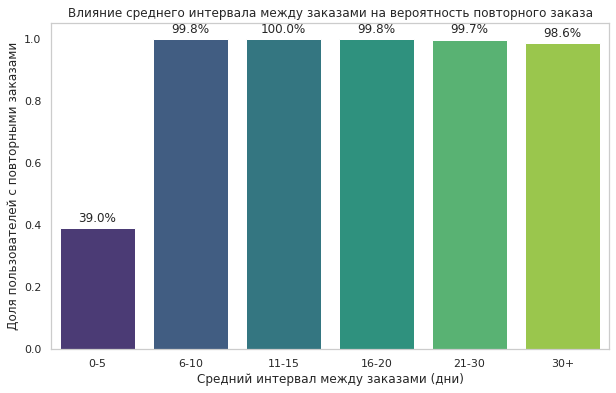

In [61]:
# Создание сегментов по среднему интервалу
bins = [0, 5, 10, 15, 20, 30, user_profile['avg_days_between_orders'].max()+1]
labels = ['0-5', '6-10', '11-15', '16-20', '21-30', '30+']
user_profile['interval_segment'] = pd.cut(user_profile['avg_days_between_orders'], bins=bins, labels=labels, right=False)

# Рассчитываем статистику по сегментам
interval_stats = user_profile.groupby('interval_segment').agg(
    users_count=('user_id', 'count'),
    repeat_share=('is_two', 'mean')
).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=interval_stats, x='interval_segment', y='repeat_share', palette='viridis')

for i, row in interval_stats.iterrows():
    plt.text(i, row['repeat_share'] + 0.02, f"{row['repeat_share']*100:.1f}%", ha='center', fontsize=12)

plt.title('Влияние среднего интервала между заказами на вероятность повторного заказа')
plt.xlabel('Средний интервал между заказами (дни)')
plt.ylabel('Доля пользователей с повторными заказами')
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)

plt.show()

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span> 

Согласно распределению, вероятность того, что клиент совершит повторную покупку билета через несколько дней (до 5 дней) после первой ничтожна мало по сравнению с другими временными интервалами. 
Чаще всего повторно приобретаются билеты после 6-30 дней с первой покупки. По истечении месяца после первой покупки наблюдается небольшое уменьшение количества потребителей.


---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

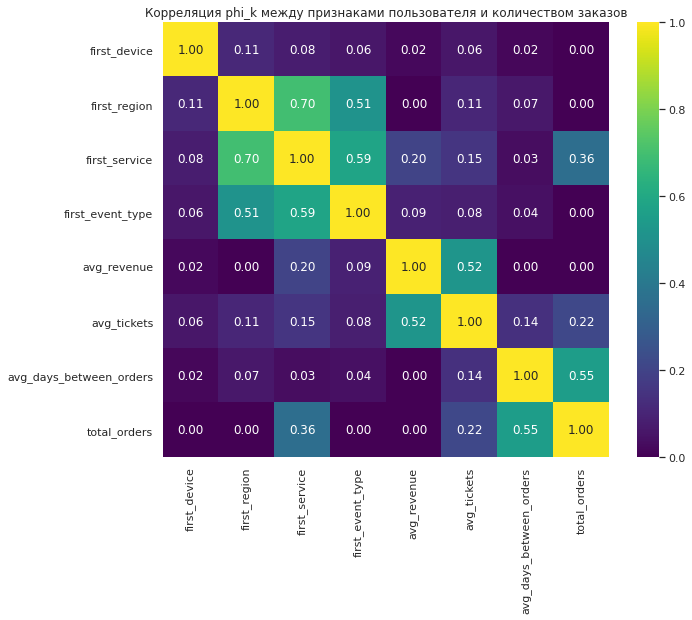

In [62]:
# Список признаков для анализа
features = [
    'first_device',
    'first_region',
    'first_service',
    'first_event_type',
    'avg_revenue',
    'avg_tickets',
    'avg_days_between_orders'
]

df_corr = user_profile[features + ['total_orders']]

# Расчет phi_k
corr_matrix = df_corr.phik_matrix(interval_cols=['avg_revenue', 'avg_tickets', 'avg_days_between_orders'])

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Корреляция phi_k между признаками пользователя и количеством заказов")

plt.show()

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Промежуточные выводы:</u></span> 

Наболее сильная связь прослеживается между числом заказов и ср количеством дней между заказами (данную зависимость также видели выше). 
Отсутствие взаимосвязи у параметра "Число заказов" зафиксирована с параметрами "Cредняя выручка с билета" и "Типу первого мероприятия". Минимальная связь наблюдается с параметром "Тип устройства, с которого совершена первая покупка".

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Характеристика данных и их подготовка:</u></span> 

- Данные проверены на пустые значения и дубликаты. Пустые значения обнаружены только в столбце days_since_prev, что является ожидаемым, т.к. они соответсвуют первой покупке пользователя; 
- Проведена сортировка по пользователю и дате; 
- Рассчитаны средняя выручка и интервал между заказами, а также ряд др показателей; 
- Созданы признаки повторных покупок; 
- Сформирован портрет потребителя по ряду параметров.

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Основные результаты анализа:</u></span> 
- В выборке 21933 уникальных пользлвателя. Доля пользователей, совершивших от 2 и более заказов равна 61,8%, от 5 и более - 21,2%; 
- Имеются большое число заказов у отдельных пользователей, что может быть объяснено корпоративной закупкой билетов; 
- Средняя выручка с одного заказа приблизительно равна 574 руб; 
- Основными точками входа первого заказа являются концерты и театр, повторных заказов - выставки, театр и концерты; 
- Мобильные пользователи являются доминирующим сегмментом входа, при этом при совершении повторных покупок распределение между мобильными и стационарными пользователями практически одинаково; 
- Рынок входа пользователей централизован вокруг нескольких крупных билетных операторов; 
- Одним из ключевых факторов возврата пользователя является "Тип мероприятия", умеренные связи наблюдаются с параметрами "Регион первого заказа" и "Билетный оператор". в свою очередь "Тип устройства" влияет мало на параметр возврата клиента; 
- Корреляционный анализ показывает, что ср выручка не связана с количеством заказов. Возможной причиной может являться то, что потребители приобретают билеты из-за интереса к мероприятию / удобства платформы, а не из-за стоимостных характеристик; 
- Основной временной характеристикой, вляющей на вероятность повторной покупки, является интервал между заказами -  пользователи с повторными заказами обычно делают следующий заказ через 6–30 дней. Слишком короткий (<5 дней) или слишком длинный (>30 дней) интервал снижает вероятность возврата; 
- День недели не очень кретичен как для первого приобретения, так и для повторного. Однако наблюдается тенденция приобретения билетов в субботу; 
- Ключевой фактор, влияющий на число покупок — это частота заказов (интервал между ними). Другие характеристики профиля и первого заказа оказывают незначительное влияние на количество совершённых покупок.

<span style="color:darkblue; text-decoration:underline; font-size:20px;"><u>Рекомендации для заказчика:</u></span> 
1. **Фокус на «успешные точки входа»** 
- Наиболее лояльные пользователи по типу мероприятия: театр, выставки; 
- Среди регионов и билетных операторов есть топ-10 сегментов с высокой долей повторных покупок — их стоит удерживать, предлагая специальные акции и персонализированные рекомендации. 
2. **Сегменты, требующие внимания и маркетинговых усилий** 
- Возврат пользователей, совершивших первый заказ с десктопа ниже, поэтому для них нужны акции по возврату, уведомления и email-кампании; 
- Клиентов с большим средним интервалом между покупками (более 30 дней) можно стимулировать на повторные заказы через скидки на следующий билет или бонусные программы; 
- У пользователей с 1–2 билетами в заказе повторная активность ниже, чем у сегмента с 2–5 билетами. Можно использовать упаковочные предложения или рекомендации мероприятий, чтобы увеличить их вовлечённость. 
3. **Факторы времени** 
- Повторные покупки чаще совершаются через 6–30 дней после первого заказа; 
- Средний интервал между заказами — основной индикатор будущей активности. Пользователи с короткими интервалами между заказами становятся наиболее активными.
